In [1]:
#Autor: Donald Ian McIntyre
#Fecha: 06/12/2023
#Fecha de entrega: 08/12/2023

### Ejercicio Técnico Etermax.
#### Objetivo: Determinar los tópicos predominantes en cada conversación del corpus adjunto

Notas:
- Se adjunta corpus (en formato csv) compuesto por la desgrabación de 640 llamadas
- Cada desgravación corresponde a un llamado en el que interviene un cliente y un agente de un contact center

Lineamientos:
- El lenguaje a utilizar es Python, y se debe entregar una Notebook en donde se puedan visualizar todos los pasos ejecutados, desde la carga del corpus, hasta la predicción de cada conversación realizada por el modelo.
- Se pueden utilizar las librerías y técnicas que se consideren, no hay limitación en cuanto a este punto.
- El código deberá ser compartido a través de una cuenta de Git.

------

#### Índice

- [Librerías](#Librerías)
- [Funciones](#Funciones)
- [Tratamiento de archivos](#Tratamiento-de-archivos)
- [Exploración de los datos](#Exploración-de-los-datos)
- [Tratamiento de textos](#Tratamiento-de-textos)
- [Modelos](#Modelos)
    - [Primera estratégia](#Primera-estratégia)
    - [BERTopic_1](#BERTopic_1)
    - [LDA_1](#LDA_1)
    - [Segunda estratégia](#Segunda-estratégia)
    - [BERTopic_2](#BERTopic_2)
    - [LDA_2](#LDA_2)
- [Resultados](#Resultados)

--------

## Librerías

In [2]:
# librerías adicionales
# !pip install gensim
# !pip install bertopic
# !pip install wordcloud
# !pip install nltk

In [3]:
# manipulación de datos
import pandas as pd
import numpy as np
import re
import os
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

# visualización de los datos
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Modelos: Latent Dirichlet Allocation (LDA) y BERTopic [modelos más populares para encontrar tópicos]
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from bertopic import BERTopic

# configuraciones
# pd.set_option('display.max_colwidth', None) # para ver entero los textos en el dataframe
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# path a carpetas
from path import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donald\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Donald\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donald\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Funciones

In [4]:
# función que prepara los textos para el modelo
def limpiar_texto(texto):
    # minúsculas
    texto = texto.lower()
    # elimina posibles números
    texto = re.sub(r'\b\d+\b', '', texto)
    # elimina texos alfanuméricos
    texto = re.sub(r'\w*\d\w*', '', texto)
    # elimina símbolos
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # tokenizador
    palabras = word_tokenize(texto)
    # me quedo con los textos que no estén dentro de los stop words
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words] #stemmer.stem(palabra)
    return ' '.join(palabras_filtradas)

# función para recortar el texto a las primeras 30 palabras
def recortar_texto(texto):
    palabras = texto.split()
    return ' '.join(palabras[:30])

## Tratamiento de archivos

In [5]:
# unifico todos los datasets en un mismo dataframe

# hago una lista con todos los archivos en la carpeta
lst_files = os.listdir(DATA_PATH)

lst_dfs = []

# itero sobre todos los archivos para crear un único archivo
for file in lst_files:
    
    # busco path y leo el archivo
    file_path = DATA_PATH + '\\' + file 
    data = pd.read_csv(file_path).reset_index()
    
    # concateno todo los textos
    texto_concatenado = ' '.join(data.iloc[0].astype(str)) # por si hay algún número
    
    # creo un df principal con todos los datos: texto concatenado y el archivo al que pertence como un "id"
    df_parcial = pd.DataFrame({'pregunta': [texto_concatenado],'corpus_id': [file.replace(".csv", "")]})
    
    lst_dfs.append(df_parcial)
    
df_main = pd.concat(lst_dfs)
df_main.reset_index(inplace=True,drop=True)

# df será mi dataframe principal para trabajar, df_main quedará para futuros análsis/tratamientos de prueba
df = df_main.copy()

In [6]:
# guardo dataframe en formato .xlsx para luego poder explorarlo a mano:
# df_main.to_excel(DATA_PROCESSED + '\\' + 'datos_procesados.xlsx', index=False)

## Exploración de los datos

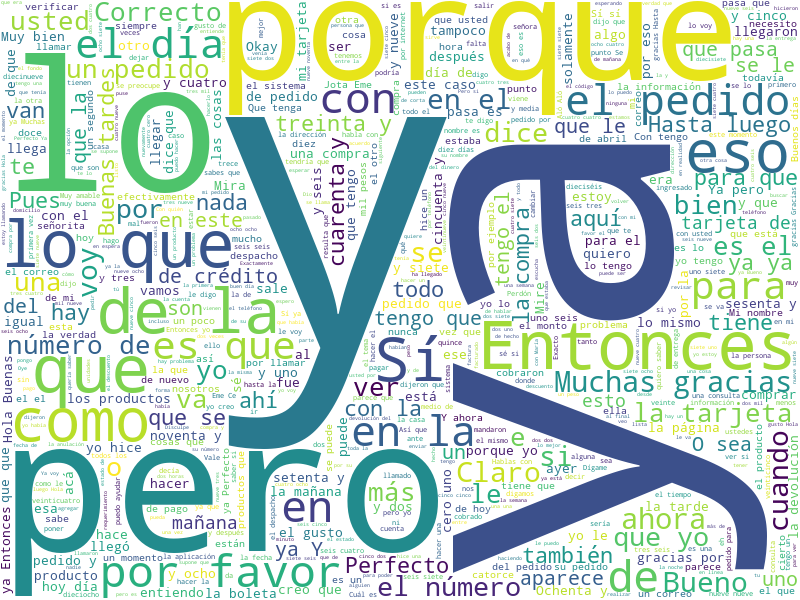

In [7]:
# nube de palabras para entender el contenido general de las llamadas
long_string = ','.join(list(df['pregunta'].values))

wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue',
                      width=800,
                      height=600
                     )

wordcloud.generate(long_string)
wordcloud.to_image()

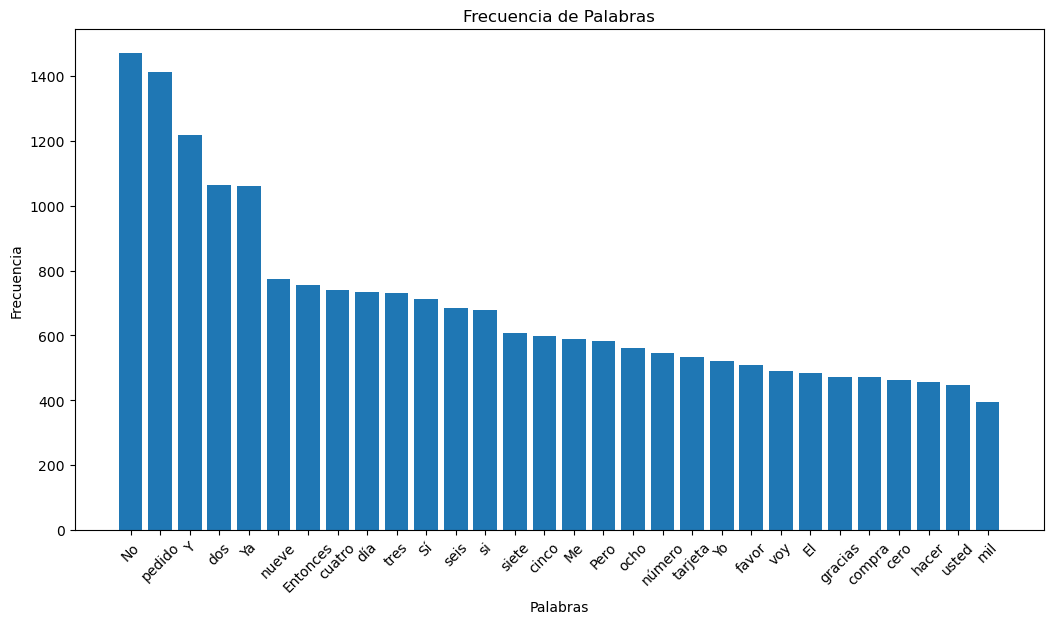

In [8]:
# gráfico de barras mostrando la frecuencia de las palabras más repetidas:
texto = df['pregunta'].str.cat(sep=' ')
texto = texto.translate(str.maketrans('', '', string.punctuation))
stop_words = set(stopwords.words('spanish'))
tokens = word_tokenize(texto, language='spanish')
tokens = [word for word in tokens if word not in stop_words]

# Contar frecuencia de palabras
frecuencia_palabras = Counter(tokens)

# Seleccionar las N palabras más comunes
plt.figure(figsize=(12.5, 6.5))
N = 30
palabras_comunes = frecuencia_palabras.most_common(N)
palabras, frecuencias = zip(*palabras_comunes)

# Crear el histograma
plt.bar(palabras, frecuencias)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Palabras')
plt.xticks(rotation=45)
plt.show()

## Tratamiento de textos

In [9]:
# Según el word cloud y las frecuencias de palabras que aparecen genero y defino Stopwords
# stopwords en español
stop_words = set(stopwords.words('spanish'))
# stop words adicionales que pueden crear ruido en los modelos:
stop_words.update(['entonces', 'voy', 'gracias', 'usted','buenas','buenos','día','tardes','días','por','ahora','hacer','dice','voy','cero', 'uno',
                   'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez','ver','así','pues','digo',
                   'once', 'doce', 'trece', 'catorce', 'quince', 'dieciséis', 'diecisiete', 'dieciocho', 
                   'diecinueve', 'veinte','veinticinco ', 'treinta', 'cuarenta', 'cincuenta', 'sesenta', 'setenta', 
                   'ochenta', 'noventa', 'cien', 'doscientos', 'trescientos', 'cuatrocientos', 'quinientos', 
                   'seiscientos', 'setecientos', 'ochocientos', 'novecientos', 'mil', 'millón', 'millones','hola',
                   'gracias','bienvenido','gusto','bien','si','cosa','claro','bueno','favor','número',
                   'perfecto','muchas','mucha','va','puede','bienvenida','bienvenido','mira','pura','nombre','ahí','quiero','mañana',
                   'hoy','correcto','aquí','punto','sé','quería','quién','aló','saber','dónde','donde','tipo','ciento','puedo',
                   'hablar','habla','hice','cosa','cosas ','caso','papá','niños','eh','eme','jota','pasa','sabes'])

#stop_words.discard('no')
#stemmer = SnowballStemmer('spanish')

In [10]:
# hago tratamiento de los textos
df['pregunta_limpia'] = df['pregunta'].apply(limpiar_texto)
# reemplazo "productos" con "procuto"
df['pregunta_limpia'] = df['pregunta_limpia'].str.replace(r'\bproductos\b', 'producto', regex=True)

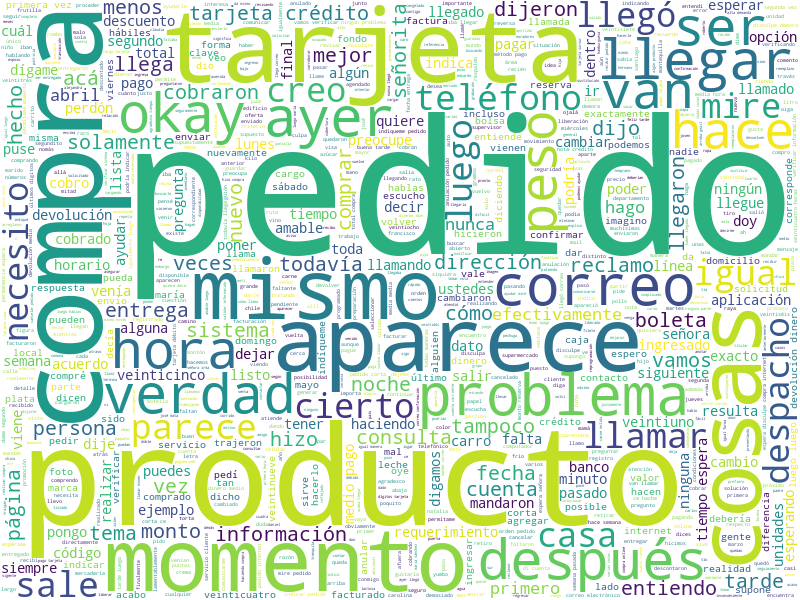

In [11]:
# nube de palabras para entender el contenido general de las llamadas
long_string = ','.join(list(df['pregunta_limpia'].values))

wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue',
                      width=800,
                      height=600
                     )

wordcloud.generate(long_string)
wordcloud.to_image()

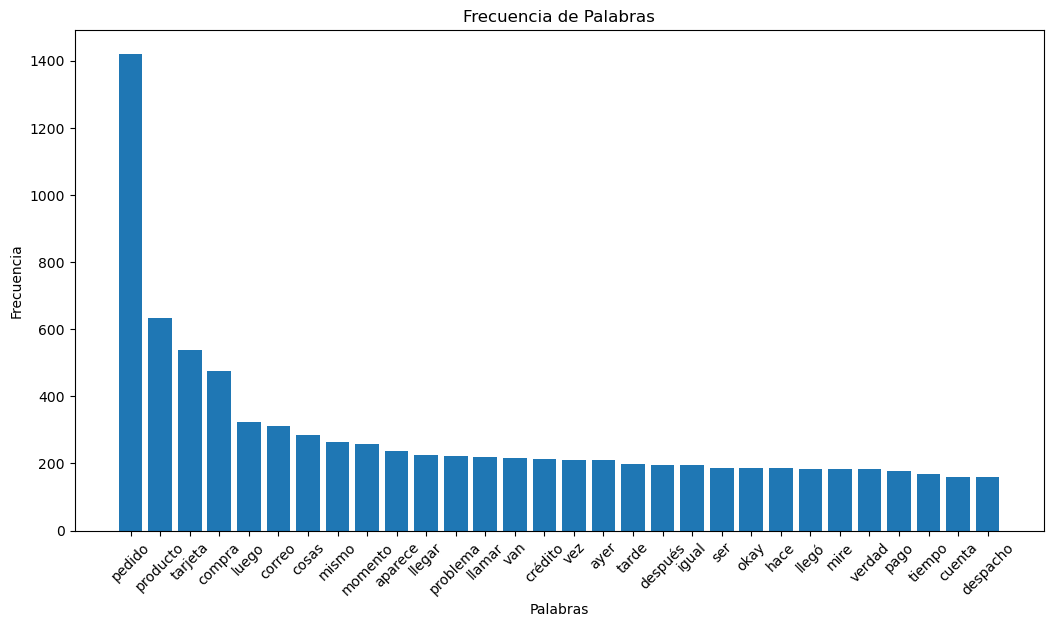

In [12]:
# gráfico de barras mostrando la frecuencia de las palabras más repetidas:
texto = df['pregunta_limpia'].str.cat(sep=' ')
texto = texto.translate(str.maketrans('', '', string.punctuation))
stop_words = set(stopwords.words('spanish'))
tokens = word_tokenize(texto, language='spanish')
tokens = [word for word in tokens if word not in stop_words]

# Contar frecuencia de palabras
frecuencia_palabras = Counter(tokens)

# Seleccionar las N palabras más comunes
plt.figure(figsize=(12.5, 6.5))
N = 30
palabras_comunes = frecuencia_palabras.most_common(N)
palabras, frecuencias = zip(*palabras_comunes)

# Crear el histograma
plt.bar(palabras, frecuencias)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Palabras')
plt.xticks(rotation=45)
plt.show()

In [13]:
from collections import Counter
tokens = [palabra for texto in df['pregunta_limpia'] for palabra in texto.split()]
frecuencia_palabras = Counter(tokens)
frecuencia_palabras.most_common(20)

[('pedido', 1420),
 ('producto', 632),
 ('tarjeta', 537),
 ('compra', 476),
 ('luego', 323),
 ('correo', 310),
 ('cosas', 285),
 ('mismo', 265),
 ('momento', 257),
 ('aparece', 236),
 ('llegar', 225),
 ('problema', 223),
 ('llamar', 220),
 ('van', 216),
 ('crédito', 213),
 ('vez', 211),
 ('ayer', 209),
 ('tarde', 198),
 ('después', 196),
 ('igual', 194)]

In [14]:
# textos con menos de 15 palabras: estos textos pueden generar ruido en los modelos ya que no aportan información.
# visualizo
df[df['pregunta'].apply(lambda x: len(x.split()) < 15)]

,pregunta,corpus_id,pregunta_limpia
28,0 Quiero saber requerimiento . Y viene,34705-16-39-20,requerimiento viene
116,tenido un poco . Entonces Mi nombre es Nata...,34714-18-26-14,natalia
150,0 Claro . Aló ?,34730-12-00-17,
200,voy a para que la parece la oferta y la val...,34758-12-14-39,parece oferta vale
223,0 ? Con quién tengo el gusto ?,34769-14-44-55,
233,. el lunes . sí .,34769-18-27-35,lunes
258,0 Treinta y ocho,34774-17-54-37,
265,0 también .,34780-09-04-00,
286,0 Bienvenido . Yo . Se le tengo el gusto .,34780-19-22-54,
326,Es el de dieciséis siete tres tres si...,34783-11-34-40,


In [15]:
# filtro estos textos
df = df[df['pregunta'].apply(lambda x: len(x.split()) >= 15)]
# y la pregutna limpia debe ser mayor o igual a 5 palabras para evadir textos que fueron muy filtrados con stop words
df = df[df['pregunta_limpia'].apply(lambda x: len(x.split()) >= 5)]

## Modelos

### Primera estratégia

Hay varias estratégias de cómo entregar textos a los modelos. En esta primera instancia, quiero ver cómo me da con todo el texto completo (habiendo sido tratado ya).

### BERTopic_1

In [16]:
df_1 = df.copy()

In [17]:
berto_1 = BERTopic(language="spanish", calculate_probabilities=True)
# Entreno modelo
topics, probabilities = berto_1.fit_transform(df_1['pregunta_limpia'])

In [18]:
# Obtener y mostrar los tópicos
for topic_num in set(topics):
    print(f"Topic {topic_num}: {berto_1.get_topic(topic_num)}\n")

Topic 0: [('pedido', 0.0762162884469217), ('tarde', 0.032780863816252385), ('llegar', 0.029695550142646007), ('entrega', 0.02717710324871711), ('ayer', 0.026644075972432592), ('señora', 0.02652908915862241), ('información', 0.025759459190362457), ('momento', 0.02550101172784162), ('luego', 0.02525024087907612), ('compra', 0.023804434153587378)]

Topic 1: [('tarjeta', 0.10249470054966149), ('crédito', 0.06470755530337118), ('compra', 0.06056395228421793), ('pedido', 0.050118031422182324), ('cuenta', 0.03272255917959012), ('vez', 0.027681195138430568), ('pago', 0.02627593142878434), ('luego', 0.025978467191965546), ('comprar', 0.02541268646953514), ('pagar', 0.024499715369090846)]

Topic 2: [('producto', 0.07102109786052559), ('pedido', 0.036533559753997184), ('cosas', 0.030632176968698608), ('unidades', 0.029148568791851556), ('llegaron', 0.028180963196846563), ('mismo', 0.026649221018043918), ('llegó', 0.02581916631124547), ('boleta', 0.02358624684084774), ('leche', 0.02240982833421458

In [19]:
data_model_1 = berto_1.get_topic_info()

In [20]:
data_model_1

,Topic,Count,Name,Representation,Representative_Docs
0,-1,220,-1_pedido_producto_tarjeta_compra,"[pedido, producto, tarjeta, compra, cosas, lue...",[ser germán mire siguiente hace poquito rato d...
1,0,134,0_pedido_tarde_llegar_entrega,"[pedido, tarde, llegar, entrega, ayer, señora,...",[comunica maría corona señorita ayudar mire pe...
2,1,88,1_tarjeta_crédito_compra_pedido,"[tarjeta, crédito, compra, pedido, cuenta, vez...",[tele conecta mire primera vez pedido online g...
3,2,70,2_producto_pedido_cosas_unidades,"[producto, pedido, cosas, unidades, llegaron, ...",[maría sánchez calderón compré cambios ningún ...
4,3,65,3_pedido_tarjeta_compra_monto,"[pedido, tarjeta, compra, monto, pesos, mismo,...",[pedido llama atención pedido línea supone ent...
5,4,16,4_compra_llegar_dijeron_acuerdo,"[compra, llegar, dijeron, acuerdo, ayer, habla...",[hablas daniela todas compra puedes llegar est...
6,5,13,5_correo_código_electrónico_preocupe,"[correo, código, electrónico, preocupe, pedido...",[atiende lópez registró ingresar entiendo dio ...


### LDA_1

In [21]:
# preparo textos para ingestarlo al modelo
texts = [text.split() for text in df_1['pregunta_limpia']]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=15, no_above=0.5)

# convertir el diccionario bag of words
bow = [dictionary.doc2bow(text) for text in texts]

# Número de tópicos
numero_topicos = 5

# LDA (parámetros seleccionados arbitrariamente para esta prueba)
lda_model_1 = LdaModel(corpus = bow,
                       id2word = dictionary,
                       num_topics = numero_topicos,
                       random_state = 100,
                       update_every = 1,
                       chunksize = 100,
                       passes = 10,
                       alpha = 'auto',
                       per_word_topics = True
                      )

In [22]:
# Ver tópicos
for idx, topic in lda_model_1.print_topics(-1):
    print('Topic: {}\nWords: {}'.format(idx, topic))

Topic: 0
Words: 0.051*"correo" + 0.025*"sale" + 0.024*"página" + 0.022*"consulta" + 0.021*"llegar" + 0.021*"luego" + 0.021*"compra" + 0.020*"despacho" + 0.019*"ayer" + 0.018*"parece"
Topic: 1
Words: 0.045*"información" + 0.035*"tarjeta" + 0.034*"sistema" + 0.034*"momento" + 0.028*"entrega" + 0.027*"anulación" + 0.024*"confirmar" + 0.024*"ayudar" + 0.022*"facturado" + 0.021*"despacho"
Topic: 2
Words: 0.047*"domingo" + 0.025*"mismo" + 0.022*"hacen" + 0.020*"dijeron" + 0.020*"salir" + 0.019*"verdad" + 0.019*"van" + 0.019*"segundo" + 0.018*"nunca" + 0.017*"esperando"
Topic: 3
Words: 0.114*"producto" + 0.032*"devolución" + 0.028*"boleta" + 0.027*"dinero" + 0.026*"vamos" + 0.026*"compra" + 0.021*"luego" + 0.019*"aparece" + 0.018*"tarjeta" + 0.018*"llamaron"
Topic: 4
Words: 0.048*"tarjeta" + 0.022*"cosas" + 0.021*"compra" + 0.020*"crédito" + 0.017*"problema" + 0.015*"después" + 0.013*"mire" + 0.012*"amable" + 0.012*"vez" + 0.012*"cuenta"


### Segunda estratégia

Ahora, esta estratégia involucra tomar las primeras 20 palabras, ya que hay conversaciones que con las primeras líneas de texto están mencionando qué es lo que quiere consultar/pedir el cliente.

In [23]:
df_2 = df.copy()

In [24]:
# recorto los textos a las primeras 30 palabras.
df_2['pregunta_limpia'] = df_2['pregunta_limpia'].apply(recortar_texto)

### BERTopic_2

In [25]:
berto_2 = BERTopic(language="spanish", calculate_probabilities=True)
# Entreno modelo
topics, probabilities = berto_2.fit_transform(df_2['pregunta_limpia'])

In [26]:
# Obtener y mostrar los tópicos
for topic_num in set(topics):
    print(f"Topic {topic_num}: {berto_2.get_topic(topic_num)}\n")

Topic 0: [('tarjeta', 0.1313179109431324), ('crédito', 0.08040136015873874), ('compra', 0.059133124303801556), ('pedido', 0.045218568362122666), ('vez', 0.03249230908464633), ('pago', 0.026609458407704567), ('monto', 0.026236135059253207), ('veces', 0.024928918078048434), ('mire', 0.024649549249963893), ('pagar', 0.0241018860947915)]

Topic 1: [('producto', 0.09736505460795813), ('pedido', 0.05467768535840318), ('cosas', 0.050926055358386714), ('llegaron', 0.04928544172182728), ('leche', 0.04539577046628711), ('llegó', 0.04035324346875193), ('cambiaron', 0.032728555899610316), ('mire', 0.02541345481028949), ('venían', 0.025235505126280366), ('pollo', 0.0247429204169866)]

Topic 2: [('pedido', 0.08060353540105072), ('ayer', 0.061293456154687155), ('señorita', 0.0382294240244796), ('miércoles', 0.033468451153157275), ('carolina', 0.0330227300290542), ('señora', 0.03295820053912368), ('tarde', 0.032778590082778024), ('llegar', 0.030791662854847395), ('vamos', 0.029987117620009426), ('indí

In [27]:
data_model_2 = berto_2.get_topic_info()

In [28]:
data_model_2

,Topic,Count,Name,Representation,Representative_Docs
0,-1,316,-1_pedido_compra_producto_mire,"[pedido, compra, producto, mire, llegar, momen...",[llamar mariana hablas pregunta pedido llegado...
1,0,77,0_tarjeta_crédito_compra_pedido,"[tarjeta, crédito, compra, pedido, vez, pago, ...",[paola consulta acabo compra online primera ve...
2,1,53,1_producto_pedido_cosas_llegaron,"[producto, pedido, cosas, llegaron, leche, lle...",[alicia hablas llamo problema pedido pedido ma...
3,2,38,2_pedido_ayer_señorita_miércoles,"[pedido, ayer, señorita, miércoles, carolina, ...",[noches bienvenidos josé mata conversar noches...
4,3,33,3_pedido_aparece_casa_señorita,"[pedido, aparece, casa, señorita, llega, domic...",[pedido página pedido hecho aparece monto pedi...
5,4,32,4_pesos_tarjeta_compra_cobraron,"[pesos, tarjeta, compra, cobraron, pedido, cue...",[hablas gabriela cómo encuentra preocupada pas...
6,5,31,5_pedido_correo_horas_llegar,"[pedido, correo, horas, llegar, información, c...",[cómo marcelo amor consulta pedido entregado m...
7,6,13,6_producto_servicio_pedido_opción,"[producto, servicio, pedido, opción, mismo, en...",[visa consulta necesito realizar compra viendo...
8,7,13,7_semanas_pedí_pedido_haciendo,"[semanas, pedí, pedido, haciendo, reclamo, oka...",[josé mata conversar josé cristian ayudar oye ...


### LDA_2

In [29]:
# preparo textos para ingestarlo al modelo
texts = [text.split() for text in df_2['pregunta_limpia']]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=15, no_above=0.5)

# convertir el diccionario bag of words
bow = [dictionary.doc2bow(text) for text in texts]

# Número de tópicos
numero_topicos = 5

# LDA (parámetros seleccionados arbitrariamente para esta prueba)
lda_model_2 = LdaModel(corpus = bow,
                       id2word = dictionary,
                       num_topics = numero_topicos,
                       random_state = 100,
                       update_every = 1,
                       chunksize = 100,
                       passes = 10,
                       alpha = 'auto',
                       per_word_topics = True
                      )

In [30]:
# Ver tópicos
for idx, topic in lda_model_2.print_topics(-1):
    print('Topic: {}\nWords: {}'.format(idx, topic))

Topic: 0
Words: 0.073*"compra" + 0.070*"tarjeta" + 0.056*"llegó" + 0.042*"okay" + 0.037*"crédito" + 0.037*"acabo" + 0.037*"hago" + 0.037*"hicieron" + 0.036*"segundo" + 0.034*"correo"
Topic: 1
Words: 0.137*"sale" + 0.106*"llegar" + 0.102*"viernes" + 0.102*"cambiaron" + 0.070*"tarde" + 0.067*"domicilio" + 0.064*"llega" + 0.064*"iba" + 0.042*"despacho" + 0.027*"pregunta"
Topic: 2
Words: 0.081*"vamos" + 0.069*"sistema" + 0.067*"tarjeta" + 0.066*"momento" + 0.057*"vez" + 0.053*"online" + 0.048*"hizo" + 0.046*"información" + 0.044*"crédito" + 0.039*"primera"
Topic: 3
Words: 0.065*"producto" + 0.045*"compra" + 0.040*"página" + 0.031*"cosas" + 0.025*"aparece" + 0.024*"mire" + 0.024*"internet" + 0.021*"consulta" + 0.020*"llamado" + 0.019*"ayer"
Topic: 4
Words: 0.071*"ayudar" + 0.049*"van" + 0.046*"indíqueme" + 0.038*"dijeron" + 0.038*"producto" + 0.034*"cómo" + 0.034*"nunca" + 0.033*"llegaron" + 0.030*"ayer" + 0.029*"teléfono"


------------

## Resultados

- Resultados:
    - Los tópicos principales parecerían ser reclamos de pedidos con retrasos, consultas del estado del pedido, problemas con los pedidos al ser entregados, y consultas de precios.
- Conclusiones:
    - BERTopic fue el modelo mejor performó, en el sentido de encontrar cuáles son los tipos de tópico principales.
    - La segunda estratégia puedo determinar un poco mejor el contenido de los textos.
- Mejoras:
    - Usar mejores técnicas de tratamiento de los textos, como el uso de "WordNetLemmatizer" para reducir las palabras a su forma base o lema y no tener que seuigr cambiando palabras a mano como "productos" a "prudcto"
    - Mejorar visualización de los resultados.
    - Eliminar los nombres de los textos.